In [87]:
import wmfdata as wmf
import pandas as pd
import numpy as np
from wmfdata import spark,hive
from datetime import datetime

In [88]:
file = "https://analytics.wikimedia.org/published/datasets/knowledge_gaps/content_gaps/csv/geography_wmf_region.csv"
geodata = pd.read_csv(file)

# filter for wikipedia projects
wikis=pd.read_csv('data/wikis')
geodata=geodata[geodata.wiki_db.isin(list(wikis['database_code']))]

In [89]:
old_geo_data = pd.read_csv('data/updated_geo_data.csv') # load current geo_data table

old_geo_data['time'] = pd.to_datetime(old_geo_data['time'])

In [90]:
# Group and pivot the geodata

    
quality_totals = geodata.groupby(['time_bucket', 'category'])['standard_quality_count_value'].sum().reset_index()
quality_totals_pivot = quality_totals.pivot(index='time_bucket', columns='category', values='standard_quality_count_value').reset_index()

quality_totals_pivot['time'] = pd.to_datetime(quality_totals_pivot['time_bucket'])

cols_to_rename = {col: col + " total" for col in quality_totals_pivot.columns if col not in ['time_bucket', 'category', 'time']}
quality_totals_pivot = quality_totals_pivot.rename(columns=cols_to_rename)


quality_totals_pivot= quality_totals_pivot[quality_totals_pivot['time'] != '2023-09-01']

In [91]:
# Identify the latest 'time' in old_geo_data

latest_time = old_geo_data['time'].max()

# Filter rows from total quality articles where 'time' is greater than latest_time from old_data to identify rows to be added
filtered_rows = quality_totals_pivot[quality_totals_pivot['time'] > latest_time]

# Filter columns of last_row based on columns in geo_data
old_geo_data = pd.concat([old_geo_data, filtered_rows], axis=0, ignore_index=True, sort=False)

old_geo_data = old_geo_data.drop(columns="time_bucket")


In [92]:
# check if new data was appended to the original csv file.

'''
The code below computes the monthly metric and the quarterly metric in the following way:

1) Monthly metric: Contained in the column called 'metric_underrepresented'.  It is computed as the MoM-difference.

2) Quarterly metric: Conatained in the column called 'quarterly_metric'.  It is computed as the average of MoM-difference of the monthly metrics of July 2023 and August 2023.  Since September data is not fully available, 
it is just the average of the first 2 months in the quarter (July and August).

'''

if filtered_rows.empty:
    print("No data has been added to the original spreadsheet. Will not overwrite updated_geo_data.csv")
    

else:
    # Compute mom difference 

    # Calculate the 12-month mom difference for each region
    old_geo_data['Latin America & Caribbean mom'] = old_geo_data['Latin America & Caribbean total'].diff().round(0)
    old_geo_data['Central & Eastern Europe & Central Asia mom'] = old_geo_data['Central & Eastern Europe & Central Asia total'].diff().round(0)
    old_geo_data['East, Southeast Asia, & Pacific mom'] = old_geo_data['East, Southeast Asia, & Pacific total'].diff().round(0)
    old_geo_data['North America mom'] = old_geo_data['North America total'].diff().round(0)
    old_geo_data['Northern & Western Europe mom'] = old_geo_data['Northern & Western Europe total'].diff().round(0)
    old_geo_data['Middle East & North Africa mom'] = old_geo_data['Middle East & North Africa total'].diff().round(0)
    old_geo_data['Sub-Saharan Africa mom'] = old_geo_data['Sub-Saharan Africa total'].diff().round(0)
    old_geo_data['South Asia mom'] = old_geo_data['South Asia total'].diff().round(0)
    old_geo_data['UNCLASSED mom'] = old_geo_data['UNCLASSED total'].diff().round(0)

    
    # Get a list of columns that contain 'mom'
    mom_columns = [col for col in old_geo_data.columns if 'mom' in col]

    # Sum the mom
    old_geo_data['sum'] = old_geo_data[mom_columns].sum(axis=1)
    

    # List of underrepresented regions
    underrepresented_regions = [
        "East, Southeast Asia, & Pacific mom", 
        "Latin America & Caribbean mom", 
        "Middle East & North Africa mom" , 
        "South Asia mom", 
        "Sub-Saharan Africa mom"
    ]
    
    # Define the columns to adjust to get quarterly average
    columns_to_adjust = [
        'Latin America & Caribbean mom',
        'Central & Eastern Europe & Central Asia mom',
        'East, Southeast Asia, & Pacific mom',
        'North America mom',
        'Northern & Western Europe mom',
        'Middle East & North Africa mom',
        'Sub-Saharan Africa mom',
        'South Asia mom',
        'UNCLASSED mom'
    ]

    
# Monthly 
    # Compute the sum of underrepresented regions
    old_geo_data['underrepresented_sum'] = old_geo_data[underrepresented_regions].sum(axis=1)

    # Calculate the proportion of underrepresented regions to total
    old_geo_data['metric_underrepresented'] = (old_geo_data['underrepresented_sum'] / old_geo_data['sum']) *100

    # drop underrepresented sum
    old_geo_data.drop('underrepresented_sum', axis=1, inplace=True)
    
    # round and turn into percentage
    #old_geo_data['underrepresented'] = old_geo_data['metric_underrepresented'] 
    #old_geo_data['metric_underrepresented'] = (old_geo_data['metric_underrepresented'] * 100).round()
    #old_geo_data['metric_underrepresented'] = old_geo_data['metric_underrepresented'].replace([np.inf, -np.inf, np.nan], 0).astype(int).astype(str) + '%'
    
# Quarterly

    # Get Quarterly metric which is the average of July and August.
    old_geo_data['time'] = pd.to_datetime(old_geo_data['time'])

    # 2. Create a copy of the DataFrame
    copied_df = old_geo_data.copy()

    # 3. Filter the copied DataFrame for the rows of August and July 2023
    august_july_data = copied_df[(copied_df['time'].dt.month.isin([8, 7])) & (copied_df['time'].dt.year == 2023)]

    # 4. Calculate the average values for August and July only for columns that contain 'total' or 'mom'
    cols_to_average = [col for col in august_july_data.columns if 'total' in col or 'mom' in col]
    average_values = august_july_data[cols_to_average].mean()

    # Replace values in the row corresponding to '2023-08-01' with average_values
    copied_df.loc[copied_df['time'] == '2023-08-01', cols_to_average] = average_values.values
    copied_df['sum'] = copied_df[columns_to_adjust].sum(axis=1)
    copied_df['undersum'] = copied_df[underrepresented_regions].sum(axis=1)
    
    # 5. Calculate the quarterly metric for the entire DataFrame
    copied_df['quarterly_metric'] = (copied_df[underrepresented_regions].sum(axis=1) / copied_df['sum']) * 100

    # 6. Append the created quarterly_metric column to old_geo_data
    old_geo_data['quarterly_metric'] = copied_df['quarterly_metric']
    


    # output
    print("updating csv file")
    old_geo_data.to_csv('data/updated_geo_data.csv', index=False)

updating csv file


In [93]:
old_geo_data.tail(1)

,time,Latin America & Caribbean total,Central & Eastern Europe & Central Asia total,"East, Southeast Asia, & Pacific total",North America total,Northern & Western Europe total,Middle East & North Africa total,Sub-Saharan Africa total,South Asia total,UNCLASSED total,...,"East, Southeast Asia, & Pacific mom",North America mom,Northern & Western Europe mom,Middle East & North Africa mom,Sub-Saharan Africa mom,South Asia mom,UNCLASSED mom,sum,metric_underrepresented,quarterly_metric
271,2023-08-01,59840,243669,162059,179267,548327,36411,28039,43486,267.0,...,1323.0,674.0,2214.0,223.0,329.0,487.0,2.0,7084.0,37.605872,33.474395


# Naive Forecast

In [94]:
'''
The forecast is derived by first determining the rate of change between the same period from the previous year and its subsequent period, considering the proportion of the total new article count. 
This rate is then applied to the current period's figures to predict the totals for our subset of interest, which are all underrepresented regions, and the overall totals. 
The predicted values are then divided. For quarterly predictions, each quarter is defined by taking the averaging the data available within that quarter."

'''
# Quarterly

# Define the months for q1 and q2
q1_dates = ['2022-07-01', '2022-08-01', '2022-09-01']
q2_dates = ['2022-10-01', '2022-11-01', '2022-12-01']

# Filter the data for q1 and q2 separately
q1_data = old_geo_data[old_geo_data['time'].isin(q1_dates)]
q2_data = old_geo_data[old_geo_data['time'].isin(q2_dates)]

# Calculate the average values for underrepresented regions and total for Q1
avg_underrepresented_q1 = q1_data[underrepresented_regions].sum(axis=1).mean()
avg_total_q1 = q1_data[columns_to_adjust].sum(axis=1).mean()

# Calculate the average values for underrepresented regions and total for Q2
avg_underrepresented_q2 = q2_data[underrepresented_regions].sum(axis=1).mean()
avg_total_q2 = q2_data[columns_to_adjust].sum(axis=1).mean()

# Calculate the rate of change from Q1 to Q2 for underrepresented regions and total
roc_underrepresented = (avg_underrepresented_q2 - avg_underrepresented_q1) / avg_underrepresented_q1
roc_total = (avg_total_q2 - avg_total_q1) / avg_total_q1

# Apply the rate of change to estimate the values for forecast
copied_df['forecasted_underrepresented'] = copied_df[underrepresented_regions].sum(axis=1) * (1 + roc_underrepresented)
copied_df['forecasted_total'] = copied_df[columns_to_adjust].sum(axis=1) * (1 + roc_total)

# Calculate the proportion of underrepresented regions in the forecasted total
copied_df['forecasted_quarterly_metric'] = copied_df['forecasted_underrepresented'] / copied_df['forecasted_total']

# Print the forecasted quarterly metric
forecast_value = copied_df.loc[copied_df['time'] == '2023-08-01', 'forecasted_quarterly_metric'].values[0]
print(f"The forecasted metric for Q2 2023 is: {forecast_value:.0%}")

# Monthly forecast

m1_dates = ['2022-08-01']
m2_dates = ['2022-09-01']

# Filter the data for m1 and m2
m1_data = old_geo_data[old_geo_data['time'].isin(m1_dates)]
m2_data = old_geo_data[old_geo_data['time'].isin(m2_dates)]

# Calculate the combined values for underrepresented regions and total for m1
combined_underrepresented_m1 = m1_data[underrepresented_regions].sum(axis=1).values[0]
total_m1 = m1_data[columns_to_adjust].sum(axis=1).values[0]

# Calculate the combined values for underrepresented regions and total for m2
combined_underrepresented_m2 = m2_data[underrepresented_regions].sum(axis=1).values[0]
total_m2 = m2_data[columns_to_adjust].sum(axis=1).values[0]

# Calculate the rate of change from m1 to m2 for underrepresented regions and total
roc_underrepresented_m = (combined_underrepresented_m2 - combined_underrepresented_m1) / combined_underrepresented_m1
roc_total_m = (total_m2 - total_m1) / total_m1

# Apply the rate of change to estimate the values in the monthly forecast
monthly_forecast = old_geo_data.copy()

monthly_forecast['forecasted_underrepresented'] = monthly_forecast[underrepresented_regions].sum(axis=1) * (1 + roc_underrepresented_m)
monthly_forecast['forecasted_total'] = monthly_forecast[columns_to_adjust].sum(axis=1) * (1 + roc_total_m)

# Calculate the proportion of underrepresented regions in the forecasted total
monthly_forecast['forecasted_monthly_metric'] = monthly_forecast['forecasted_underrepresented'] / monthly_forecast['forecasted_total']

# Print the forecasted metric for the row of 2023-08-01
forecast_value_m = monthly_forecast.loc[monthly_forecast['time'] == '2023-08-01', 'forecasted_monthly_metric'].values[0]
print(f"The forecasted monthly metric for September 2023 is: {forecast_value_m:.2%}")



The forecasted metric for Q2 2023 is: 35%
The forecasted monthly metric for September 2023 is: 37.07%


# Monthly Metric Graph

Generating region chart..
           time  Latin America & Caribbean total  \
0    2001-01-01                                0   
1    2001-02-01                                0   
2    2001-03-01                                0   
3    2001-04-01                                0   
4    2001-05-01                                0   
..          ...                              ...   
267  2023-04-01                            58862   
268  2023-05-01                            59063   
269  2023-06-01                            59231   
270  2023-07-01                            59538   
271  2023-08-01                            59840   

     Central & Eastern Europe & Central Asia total  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   
..                       

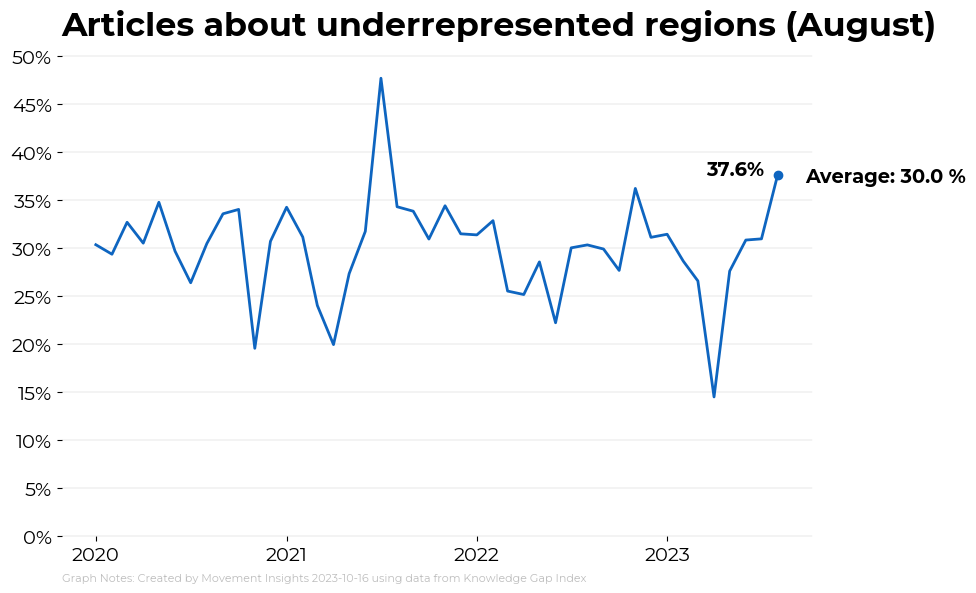

In [95]:
%run geo_data_plot.ipynb